# Satellite Imagery for Road quality assessments with UP42

Pre-Sales Engineer Challenge by Nisleida Morales Ruiz

### 0. Initialization

Install

In [1]:
#!pip install geoplot
#!pip install geojsonio
#!pip install up42-py
#!pip install ipyleaflet
#!pip install geemap

Import

In [84]:
import pandas as pd
import geopandas as gpd
import folium
import up42
import os
import geemap
import json

### 1. Define Area of Interest (aoi)

Read road alignment file and check crs

In [18]:
# Read road alignment 
road_alignment = gpd.read_file('./resources/road_alignment.geojson')

# Check Coordinate Reference Systems
print(road_alignment.crs)


epsg:32636


In [19]:
# Transform coordinate system
road_alignment = road_alignment.to_crs('EPSG:4326')

Buffer around road alignment

In [20]:
# Business Specification: corridor that is 500m wide (250m buffer)

# Length of one degree of longitude at the equator (in kilometers)
length_of_degree_at_equator = 111.111  # Approximately 111 kilometers

# Desired buffer width (in meters)
corridor_wide = 500.0  # 500 meters

# Convert desired buffer width from meters to kilometers
corridor_wide_km = corridor_wide / 1000

# Calculate buffer distance width in degrees
aoi_buffer_degrees = (corridor_wide_km / length_of_degree_at_equator)/2


In [21]:
# Create a buffer around the road
buffer_distance = aoi_buffer_degrees  
road_alignment_buffer = road_alignment.buffer(buffer_distance)

# Convert GeoDataFrame to GeoJSON
aoi = road_alignment_buffer.to_json()
geojson_data_line = road_alignment.to_json()

C:\Users\Nisleida Morales\AppData\Local\Temp\ipykernel_3384\657316554.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_alignment_buffer = road_alignment.buffer(buffer_distance)


Visualize aoi

In [22]:
# Create a base map
m = folium.Map(location=[road_alignment.geometry.centroid.y.mean(), road_alignment.geometry.centroid.x.mean()], zoom_start=10)

# Add the buffer layer to the map
folium.GeoJson(aoi, name='Buffer').add_to(m)

# Add the road line layer to the map
folium.GeoJson(geojson_data_line, name='Road Alignment').add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Show the map
m

C:\Users\Nisleida Morales\AppData\Local\Temp\ipykernel_3384\898948169.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[road_alignment.geometry.centroid.y.mean(), road_alignment.geometry.centroid.x.mean()], zoom_start=10)
C:\Users\Nisleida Morales\AppData\Local\Temp\ipykernel_3384\898948169.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[road_alignment.geometry.centroid.y.mean(), road_alignment.geometry.centroid.x.mean()], zoom_start=10)


Save aoi as geojson

In [25]:
# Convert the buffer to a GeoDataFrame
road_alignment_buffer_gdf = gpd.GeoDataFrame(geometry=road_alignment_buffer, crs='EPSG:4326')

# Save the buffer as a GeoJSON file
aoi = './outputs_geojson/road_alignment_buffer.geojson'
road_alignment_buffer_gdf.to_file(aoi, driver='GeoJSON')

### 2. Search available catalogs with UP42 Python SDK

Authentication in up42

In [27]:
# Authenticate with up42 credentials file. Register: https://console.up42.com/register

# SDK documentation https://sdk.up42.com/

def authenticate_with_credentials_file(credentials_file="./resources/credentials.json"):

    # Check if the credentials file exists
    if os.path.isfile(credentials_file):
        try:
            up42.authenticate(cfg_file=credentials_file)
            print("Authenticated 👍")
        except Exception as e:
            print("not authenticated:", e)
    else:
        print("Credentials file not found")


authenticate_with_credentials_file()

2024-02-26 17:36:28,460 - Authentication with UP42 successful!


Authenticated 👍


Construct a DataFrame containing data from all catalogs

In [28]:
# Initialize Catalog
catalog = up42.initialize_catalog()

# Available data collections
collection_list = catalog.get_collections()

# Convert list of dictionaries to DataFrame
collection_df = pd.DataFrame(collection_list)

# Display DataFrame
collection_df

,name,title,description,type,restricted,host,hostName,producer,producerName,isIntegrated,isOptical,resolutionClass,productType,resolutionValue,createdAt,updatedAt
0,pneo,Pléiades Neo,Very high resolution 30 cm optical satellite i...,ARCHIVE,False,"{'name': 'oneatlas', 'title': 'OneAtlas', 'des...",oneatlas,"{'name': 'airbus', 'title': 'Airbus', 'descrip...",airbus,True,True,VERY_HIGH,OPTICAL,"{'minimum': 0.3, 'maximum': None}",2022-04-21T13:01:00.656522Z,2023-10-05T15:33:16.486420Z
1,landsat-8,Landsat 8,Free low resolution 30 m optical and thermal s...,ARCHIVE,False,"{'name': 'earthsearch-aws', 'title': 'Earth Se...",earthsearch-aws,"{'name': 'usgs', 'title': 'USGS', 'description...",usgs,True,True,LOW,OPTICAL,"{'minimum': 30, 'maximum': None}",2023-11-14T09:48:20.054738Z,2023-11-15T10:00:27.770645Z
2,hexagon-na-30cm,Hexagon — North America 30 cm,Very high resolution 30 cm optical aerial imag...,ARCHIVE,False,"{'name': 'hexagon', 'title': 'Hexagon', 'descr...",hexagon,"{'name': 'hexagon', 'title': 'Hexagon', 'descr...",hexagon,True,True,VERY_HIGH,OPTICAL,"{'minimum': 0.3, 'maximum': None}",2023-03-22T12:41:28Z,2023-10-05T15:43:33.108568Z
3,hexagon-na-15cm,Hexagon — North America 15 cm,Very high resolution 15 cm optical aerial imag...,ARCHIVE,False,"{'name': 'hexagon', 'title': 'Hexagon', 'descr...",hexagon,"{'name': 'hexagon', 'title': 'Hexagon', 'descr...",hexagon,True,True,VERY_HIGH,OPTICAL,"{'minimum': 0.3, 'maximum': None}",2023-03-22T12:41:28Z,2023-10-05T15:43:53.795986Z
4,vexcel-us-6cm-oblique,Vexcel Aerial Oblique — US 5.5 cm,Very high resolution 5.5 cm optical aerial ima...,ARCHIVE,False,"{'name': 'vexcel', 'title': 'Vexcel', 'descrip...",vexcel,"{'name': 'vexcel', 'title': 'Vexcel', 'descrip...",vexcel,True,True,VERY_HIGH,OPTICAL,"{'minimum': 0.055, 'maximum': None}",2023-06-14T01:32:39Z,2023-10-05T15:50:15.095888Z
5,vexcel-oc-6cm-trueortho,Vexcel Aerial True Ortho — Oceania 5.5 cm,Very high resolution 5.5 cm optical aerial ima...,ARCHIVE,False,"{'name': 'vexcel', 'title': 'Vexcel', 'descrip...",vexcel,"{'name': 'vexcel', 'title': 'Vexcel', 'descrip...",vexcel,True,True,VERY_HIGH,OPTICAL,"{'minimum': 0.055, 'maximum': None}",2023-06-14T01:32:05Z,2023-10-05T15:51:02.986904Z
6,sentinel-2,Sentinel-2,Free medium resolution 10 m optical satellite ...,ARCHIVE,False,"{'name': 'earthsearch-aws', 'title': 'Earth Se...",earthsearch-aws,"{'name': 'esa', 'title': 'European Space Agenc...",esa,True,True,MEDIUM,OPTICAL,"{'minimum': 10.0, 'maximum': None}",2023-03-21T13:38:11.318823Z,2023-10-05T15:42:36.698998Z
7,nextmap10-dsm,NEXTMap 10 DSM,A medium resolution 10 m digital surface model...,ARCHIVE,True,"{'name': 'intermap', 'title': 'Intermap', 'des...",intermap,"{'name': 'intermap', 'title': 'Intermap', 'des...",intermap,True,False,MEDIUM,ELEVATION,"{'minimum': 10.0, 'maximum': None}",2022-11-15T13:13:10.670388Z,2023-10-05T15:34:35.259346Z
8,nextmap6-dtm,NEXTMap 6 DTM,"A medium resolution 6 m digital terrain model,...",ARCHIVE,True,"{'name': 'intermap', 'title': 'Intermap', 'des...",intermap,"{'name': 'intermap', 'title': 'Intermap', 'des...",intermap,True,False,MEDIUM,ELEVATION,"{'minimum': 6.0, 'maximum': None}",2022-11-15T13:11:47.791048Z,2023-10-05T15:38:28.797062Z
9,vexcel-oc-6cm-dsm,Vexcel Elevate DSM — Oceania 5.5 cm,A very high resolution 5.5 cm digital surface ...,ARCHIVE,False,"{'name': 'vexcel', 'title': 'Vexcel', 'descrip...",vexcel,"{'name': 'vexcel', 'title': 'Vexcel', 'descrip...",vexcel,True,False,VERY_HIGH,ELEVATION,"{'minimum': 0.055, 'maximum': None}",2023-06-14T01:32:24Z,2023-10-05T15:45:59.674905Z


In [29]:
# Check catalogs with minimum resolution according to business specification (30cm data where possible and filling in with 50cm when needed)

#Create a column with the value as numeric of resolution in centimeters (now is in meters)

def min_resolution(row):
    min_value = row['resolutionValue']['minimum']  # Minimum value of resolution
    if min_value is not None:
        return min_value * 100 # Convert to cm
    else:
        return None

# Create new numeric column for min_resolution_cm
collection_df['min_resolution_cm'] = collection_df.apply(min_resolution, axis=1).apply(pd.to_numeric, errors='coerce')

Explore the Catalogs information

In [30]:
print(f"Collections attributes: \n {list(collection_df.columns)}\n")

print(f"Collection size: {len(collection_df)}\n")

print(f"Unique product type: \n {collection_df['productType'].unique()}\n")

print(f"Unique host: \n {list(collection_df['hostName'].unique())}\n")

print(f"Top min resolution of all catalogs: {collection_df['min_resolution_cm'].max()}\n")

print(f"Count catalogs with resolution less than 50 cm: {(collection_df['min_resolution_cm']<= 50).sum()}\n")

Collections attributes: 
 ['name', 'title', 'description', 'type', 'restricted', 'host', 'hostName', 'producer', 'producerName', 'isIntegrated', 'isOptical', 'resolutionClass', 'productType', 'resolutionValue', 'createdAt', 'updatedAt', 'min_resolution_cm']

Collection size: 50

Unique product type: 
 ['OPTICAL' 'ELEVATION' 'SAR']

Unique host: 
 ['oneatlas', 'earthsearch-aws', 'hexagon', 'vexcel', 'intermap', 'capellaspace', 'airbus-elevation', '21at', 'nearspacelabs', 'imagesat']

Top min resolution of all catalogs: 3000.0

Count catalogs with resolution less than 50 cm: 37



Filter catalogs

In [37]:
# Determinate possible catalogs according with business specifications, d

filtered_collections_df = collection_df[(collection_df['min_resolution_cm'] <= 50.0) & # less than 50 cm of min resolution
                            (collection_df['productType'] != 'ELEVATION') & # not elevation type
                            (collection_df['type'] == 'ARCHIVE') & # archive data
                            (~collection_df['restricted'])] # be unrestricted

# Check remaining number of catalogs
print(f"Remaining number of catalogs that match: {len(filtered_collections_df)}\n")

# Create array with name of catalogs
catalog_names_array = filtered_collections_df['name'].values
print(f"Catalogs: \n preference 30cm data or with 50cm when needed \n {catalog_names_array}")

Remaining number of catalogs that match: 22

Catalogs: 
 preference 30cm data or with 50cm when needed 
 ['pneo' 'hexagon-na-30cm' 'hexagon-na-15cm' 'vexcel-us-6cm-oblique'
 'vexcel-oc-6cm-trueortho' 'vexcel-ca-6cm-trueortho' 'phr'
 'hexagon-eu-30cm' 'vexcel-eeu-6cm-trueortho' 'nsl-30cm'
 'vexcel-ca-6cm-oblique' 'vexcel-jp-6cm-oblique' 'vexcel-oc-6cm-oblique'
 'vexcel-eeu-6cm-oblique' 'vexcel-us-15cm-ortho' 'vexcel-jp-6cm-trueortho'
 'vexcel-weu-6cm-trueortho' 'vexcel-us-6cm-trueortho'
 'vexcel-weu-6cm-oblique' 'eros-b' 'vexcel-weu-15cm-ortho' 'eros-c']


### 3. Catalog data search

In [38]:
# Read aio
aoi = up42.read_vector_file(aoi, as_dataframe=False)

Define search parameters

In [40]:
# Parameters
start_date_search="2023-05-01"
end_date_search="2023-09-30"
max_cloudcover=20
limit=10


Search in all catalogs and store all results in 1 dataframe

In [52]:
# Initialize an empty list to store search results
all_results = []

for i in catalog_names_array:
    search_parameters = catalog.construct_search_parameters(
        collections=[i],
        geometry=aoi,
        start_date=start_date_search,
        end_date=end_date_search,
        max_cloudcover=max_cloudcover,
        limit=limit,
    )
    search_results_df = catalog.search(search_parameters, as_dataframe=True)
    print(f"{str([i])}\n")
    
    # Add the search results to the list
    all_results.append(search_results_df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_results_df = pd.concat(all_results, ignore_index=True)

# Save the json of the results
combined_results_json = combined_results_df.to_json()

#Visualize results
combined_results_df 

2024-02-26 17:53:11,537 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056), (30.84426805023462, 40.83151616122415), (30.

['pneo']



2024-02-26 17:53:13,656 - 0 results returned.
2024-02-26 17:53:13,672 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['hexagon-na-30cm']



2024-02-26 17:53:14,069 - 0 results returned.
2024-02-26 17:53:14,084 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['hexagon-na-15cm']



2024-02-26 17:53:14,510 - 0 results returned.
2024-02-26 17:53:14,524 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-us-6cm-oblique']



2024-02-26 17:53:15,025 - 0 results returned.
2024-02-26 17:53:15,038 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-oc-6cm-trueortho']



2024-02-26 17:53:15,712 - 0 results returned.
2024-02-26 17:53:15,722 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-ca-6cm-trueortho']



2024-02-26 17:53:17,026 - 2 results returned.
2024-02-26 17:53:17,041 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['phr']



2024-02-26 17:53:17,421 - 0 results returned.
2024-02-26 17:53:17,421 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['hexagon-eu-30cm']



2024-02-26 17:53:17,989 - 0 results returned.
2024-02-26 17:53:18,010 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-eeu-6cm-trueortho']



2024-02-26 17:53:18,504 - 0 results returned.
2024-02-26 17:53:18,504 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['nsl-30cm']



2024-02-26 17:53:18,943 - 0 results returned.
2024-02-26 17:53:18,961 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-ca-6cm-oblique']



2024-02-26 17:53:19,389 - 0 results returned.
2024-02-26 17:53:19,402 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-jp-6cm-oblique']



2024-02-26 17:53:19,809 - 0 results returned.
2024-02-26 17:53:19,821 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-oc-6cm-oblique']



2024-02-26 17:53:20,172 - 0 results returned.
2024-02-26 17:53:20,188 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-eeu-6cm-oblique']



2024-02-26 17:53:20,602 - 0 results returned.
2024-02-26 17:53:20,608 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-us-15cm-ortho']



2024-02-26 17:53:21,025 - 0 results returned.
2024-02-26 17:53:21,025 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-jp-6cm-trueortho']



2024-02-26 17:53:21,440 - 0 results returned.
2024-02-26 17:53:21,448 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-weu-6cm-trueortho']



2024-02-26 17:53:21,885 - 0 results returned.
2024-02-26 17:53:21,901 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-us-6cm-trueortho']



2024-02-26 17:53:22,307 - 0 results returned.
2024-02-26 17:53:22,322 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-weu-6cm-oblique']



2024-02-26 17:53:23,322 - 0 results returned.
2024-02-26 17:53:23,322 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['eros-b']



2024-02-26 17:53:23,754 - 0 results returned.
2024-02-26 17:53:23,754 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-weu-15cm-ortho']



2024-02-26 17:53:24,758 - 0 results returned.


['eros-c']



,geometry,id,constellation,collection,providerName,up42:usageType,providerProperties,sceneId,producer,acquisitionDate,start_datetime,end_datetime,cloudCoverage,resolution,deliveryTime
0,"POLYGON ((30.99118 40.90586, 30.80048 40.89398...",775c7747-e9aa-4b62-ae2c-864e4187a744,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",775c7747-e9aa-4b62-ae2c-864e4187a744,airbus,2023-09-27T08:53:38Z,None,None,0.000000,0.30,HOURS
1,"POLYGON ((31.27022 41.13301, 31.09351 41.12759...",84c8319e-b4ed-4545-b6f0-4d1e8d892cf3,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",84c8319e-b4ed-4545-b6f0-4d1e8d892cf3,airbus,2023-09-27T08:53:16Z,None,None,1.800000,0.30,HOURS
2,"POLYGON ((32.13696 41.37362, 31.94628 41.36041...",1b5b8a3b-332f-439e-b437-5d6b91b4956b,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",1b5b8a3b-332f-439e-b437-5d6b91b4956b,airbus,2023-09-19T08:49:45Z,None,None,0.000000,0.30,HOURS
3,"POLYGON ((31.13509 40.90965, 30.94445 40.89795...",345d8a62-d91c-412c-97e9-c790ffef72bc,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",345d8a62-d91c-412c-97e9-c790ffef72bc,airbus,2023-09-14T08:53:39Z,None,None,0.000000,0.30,HOURS
4,"POLYGON ((31.99639 40.79008, 31.80805 40.78110...",408958c2-18b0-4bac-b356-d3bc228516fc,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",408958c2-18b0-4bac-b356-d3bc228516fc,airbus,2023-08-24T08:49:55Z,None,None,1.000000,0.30,HOURS
5,"POLYGON ((31.57554 40.78599, 31.37020 40.77659...",f1436243-70b7-49a9-8aaa-25f4e239bc1d,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",f1436243-70b7-49a9-8aaa-25f4e239bc1d,airbus,2023-07-22T09:04:19Z,None,None,0.000000,0.30,HOURS
6,"POLYGON ((31.13780 40.89544, 30.94359 40.89292...",1024182c-172b-4dd7-afeb-729cac13ab52,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",1024182c-172b-4dd7-afeb-729cac13ab52,airbus,2023-07-22T09:04:08Z,None,None,0.000000,0.30,HOURS
7,"POLYGON ((31.51484 40.78453, 31.51504 40.64676...",a71e31b7-f8df-4bbb-9a71-0613d0879a61,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2023-0...",a71e31b7-f8df-4bbb-9a71-0613d0879a61,airbus,2023-07-22T09:03:56Z,None,None,0.000000,0.30,HOURS
8,"POLYGON ((30.36862 40.79519, 30.36937 40.64664...",208ea680-1a79-45ca-9dd3-43bec606204c,pneo,pneo,oneatlas,[DATA],"{'commercialReference': '000114077', 'qualifie...",208ea680-1a79-45ca-9dd3-43bec606204c,airbus,2023-07-21T08:46:04Z,None,None,0.000000,0.36,MINUTES
9,"POLYGON ((30.22590 40.90175, 30.22361 40.64843...",152a68a0-c1a7-479f-9f1f-c5e9e20f35c5,pneo,pneo,oneatlas,[DATA],"{'commercialReference': '000112760', 'qualifie...",152a68a0-c1a7-479f-9f1f-c5e9e20f35c5,airbus,2023-07-17T09:07:33Z,None,None,0.011126,0.34,MINUTES


In [48]:
print(f"Catalogs with results: {combined_results_df['collection'].unique()}")

Catalogs with results: ['pneo' 'phr']


In [49]:
# pneo has more results than phr and has better resolution

Save the results segregated by catalog

In [70]:
# Iterate through each catalog to store the results individually

for catalog_name in catalog_names_array:
    search_parameters = catalog.construct_search_parameters(
        collections=[catalog_name],
        geometry=aoi,
        start_date=start_date_search,
        end_date=end_date_search,
        max_cloudcover=max_cloudcover,
        limit=limit,
    )
    
    # Perform the search and store the result in a variable with the catalog name
    globals()[f"search_results_df_{catalog_name}"] = catalog.search(search_parameters, as_dataframe=True)
    globals()[f"search_results_json_{catalog_name}"] = catalog.search(search_parameters, as_dataframe=False)
    print(f"{str([catalog_name])}\n")


2024-02-26 18:14:46,853 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056), (30.84426805023462, 40.83151616122415), (30.

['pneo']



2024-02-26 18:14:50,448 - 0 results returned.
2024-02-26 18:14:50,451 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['hexagon-na-30cm']



2024-02-26 18:14:51,340 - 0 results returned.
2024-02-26 18:14:51,357 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['hexagon-na-15cm']



2024-02-26 18:14:52,157 - 0 results returned.
2024-02-26 18:14:52,157 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-us-6cm-oblique']



2024-02-26 18:14:52,984 - 0 results returned.
2024-02-26 18:14:52,984 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-oc-6cm-trueortho']



2024-02-26 18:14:53,807 - 0 results returned.
2024-02-26 18:14:53,807 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-ca-6cm-trueortho']



2024-02-26 18:14:55,009 - 2 results returned.
2024-02-26 18:14:55,009 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['phr']



2024-02-26 18:14:56,046 - 0 results returned.
2024-02-26 18:14:56,046 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['hexagon-eu-30cm']



2024-02-26 18:14:56,908 - 0 results returned.
2024-02-26 18:14:56,908 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-eeu-6cm-trueortho']



2024-02-26 18:14:57,771 - 0 results returned.
2024-02-26 18:14:57,771 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['nsl-30cm']



2024-02-26 18:14:58,620 - 0 results returned.
2024-02-26 18:14:58,620 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-ca-6cm-oblique']



2024-02-26 18:14:59,434 - 0 results returned.
2024-02-26 18:14:59,434 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-jp-6cm-oblique']



2024-02-26 18:15:00,301 - 0 results returned.
2024-02-26 18:15:00,301 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-oc-6cm-oblique']



2024-02-26 18:15:01,192 - 0 results returned.
2024-02-26 18:15:01,192 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-eeu-6cm-oblique']



2024-02-26 18:15:02,179 - 0 results returned.
2024-02-26 18:15:02,179 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-us-15cm-ortho']



2024-02-26 18:15:03,090 - 0 results returned.
2024-02-26 18:15:03,106 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-jp-6cm-trueortho']



2024-02-26 18:15:04,024 - 0 results returned.
2024-02-26 18:15:04,024 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-weu-6cm-trueortho']



2024-02-26 18:15:07,515 - 0 results returned.
2024-02-26 18:15:07,520 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-us-6cm-trueortho']



2024-02-26 18:15:08,569 - 0 results returned.
2024-02-26 18:15:08,577 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-weu-6cm-oblique']



2024-02-26 18:15:10,219 - 0 results returned.
2024-02-26 18:15:10,219 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['eros-b']



2024-02-26 18:15:11,826 - 0 results returned.
2024-02-26 18:15:11,828 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['vexcel-weu-15cm-ortho']



2024-02-26 18:15:13,342 - 0 results returned.
2024-02-26 18:15:13,342 - Searching catalog with search_parameters: {'datetime': '2023-05-01T00:00:00Z/2023-09-30T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819416, 40.82457033971056)

['eros-c']



### 4. Download the results as quicklooks

Define the id of the results

In [56]:
# image_id of the general results
 
image_id_search = list(combined_results_df['sceneId'].values)
print(image_id_search)

# collection name of the image_id of the general results

collections_search = combined_results_df['collection'].values
print(collections_search)

['775c7747-e9aa-4b62-ae2c-864e4187a744', '84c8319e-b4ed-4545-b6f0-4d1e8d892cf3', '1b5b8a3b-332f-439e-b437-5d6b91b4956b', '345d8a62-d91c-412c-97e9-c790ffef72bc', '408958c2-18b0-4bac-b356-d3bc228516fc', 'f1436243-70b7-49a9-8aaa-25f4e239bc1d', '1024182c-172b-4dd7-afeb-729cac13ab52', 'a71e31b7-f8df-4bbb-9a71-0613d0879a61', '208ea680-1a79-45ca-9dd3-43bec606204c', '152a68a0-c1a7-479f-9f1f-c5e9e20f35c5', 'efefde7e-966e-4a67-8b1d-c21df36aa948', '03cb4b1c-8567-4312-a9c8-d38662adabf4']
['pneo' 'pneo' 'pneo' 'pneo' 'pneo' 'pneo' 'pneo' 'pneo' 'pneo' 'pneo'
 'phr' 'phr']


In [57]:
# image_id for catalog

image_id_search_pneo = list(search_results_df_pneo['sceneId'].values)
image_id_search_phr = list(search_results_df_phr['sceneId'].values)

In [58]:
# Download quicklooks (the download must be by collection)

for i in collections_search:
    catalog.download_quicklooks(
        image_ids=image_id_search,
        collection= i,
        output_directory="./outputs_quicklooks/",
    )

2024-02-26 18:00:42,309 - Downloading quicklooks from provider oneatlas.
2024-02-26 18:00:42,311 - Download directory: outputs_quicklooks
100%|██████████| 12/12 [00:28<00:00,  2.38s/it]
2024-02-26 18:01:10,899 - Downloading quicklooks from provider oneatlas.
2024-02-26 18:01:10,899 - Download directory: outputs_quicklooks
100%|██████████| 12/12 [00:17<00:00,  1.49s/it]
2024-02-26 18:01:28,772 - Downloading quicklooks from provider oneatlas.
2024-02-26 18:01:28,774 - Download directory: outputs_quicklooks
100%|██████████| 12/12 [00:15<00:00,  1.29s/it]
2024-02-26 18:01:44,296 - Downloading quicklooks from provider oneatlas.
2024-02-26 18:01:44,296 - Download directory: outputs_quicklooks
100%|██████████| 12/12 [00:20<00:00,  1.67s/it]
2024-02-26 18:02:04,364 - Downloading quicklooks from provider oneatlas.
2024-02-26 18:02:04,366 - Download directory: outputs_quicklooks
100%|██████████| 12/12 [00:15<00:00,  1.31s/it]
2024-02-26 18:02:20,047 - Downloading quicklooks from provider oneatla

Visualize quicklooks

In [98]:
# Visualize all quicklooks

#catalog.map_quicklooks(scenes=combined_results_df, aoi=aoi)

In [99]:
# Visualize pneo quicklooks

#catalog.map_quicklooks(scenes=search_results_df_pneo, aoi=aoi)

Plot quicklooks

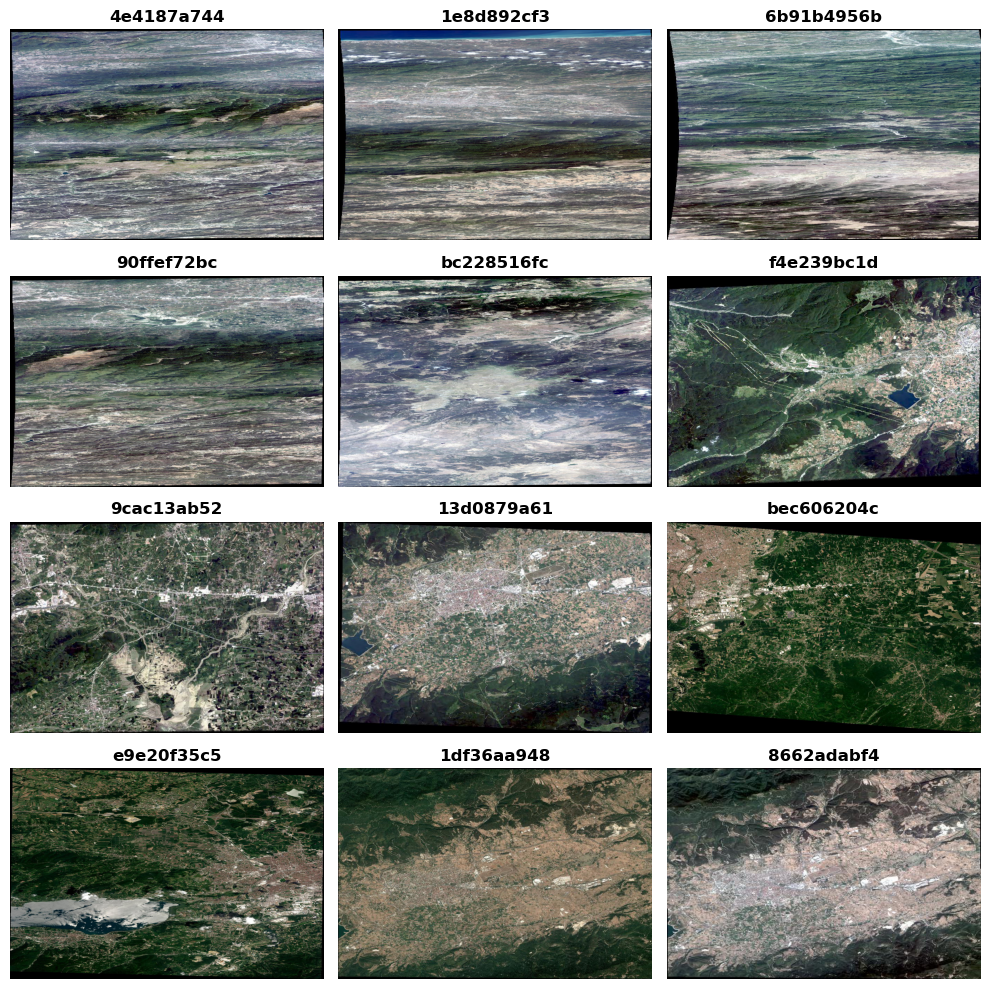

In [62]:
# Plot as titles just the last 10 numbers of the id
titles_results = list(combined_results_df['id'].str[-10:].values)

# Plot all the results
catalog.plot_quicklooks( figsize=(10, 10), titles= titles_results)

### 5. Export results as vector files (for GIS or jupyter notebook)

In [67]:
# Check keys of the dict
print(search_results_df_pneo.keys())

Index(['geometry', 'id', 'constellation', 'collection', 'providerName',
       'providerProperties', 'sceneId', 'producer', 'acquisitionDate',
       'start_datetime', 'end_datetime', 'cloudCoverage', 'resolution',
       'deliveryTime'],
      dtype='object')


Export as Geojson pneo

In [71]:
# Remove fields of type list to export to geojson
del search_results_df_pneo['up42:usageType']

# Export to geojson
search_results_df_pneo.to_file('./outputs_geojson/search_results_pneo.geojson', driver='GeoJSON')

Export as Geojson phr

In [ ]:
# Remove fields of type list to export to geojson
del search_results_df_phr['up42:usageType']

# Export to geojson
search_results_df_phr.to_file('./outputs_geojson/search_results_phr.geojson', driver='GeoJSON')

Export as Geojson all results

In [72]:
# Remove fields of type list to export to geojson
del combined_results_df['up42:usageType']

# Export to geojson
combined_results_df.to_file('./outputs_geojson/search_results.geojson', driver='GeoJSON')

Plot results as geojson

In [75]:
search_results_geojson = "./outputs_geojson/search_results.geojson"

In [87]:
# Define colors for each layer
line_color = 'blue'
buffer_color = 'green'
result_color = 'red'

# Create a base map
m_results = folium.Map(location=[road_alignment.geometry.centroid.y.mean(), road_alignment.geometry.centroid.x.mean()], zoom_start=10)

# Add the buffer layer to the map
folium.GeoJson(aoi, name='Buffer', style_function=lambda x: {'fillColor': buffer_color, 'color': buffer_color}).add_to(m_results)

# Add the road line layer to the map
folium.GeoJson(geojson_data_line, name='Road Alignment', style_function=lambda x: {'color': line_color}).add_to(m_results)

# Add the result layer to the map
folium.GeoJson(search_results_geojson, name='Results', style_function=lambda x: {'fillColor': result_color, 'color': result_color}).add_to(m_results)

# Add layer control
folium.LayerControl().add_to(m_results)

# Show the map
m_results


C:\Users\Nisleida Morales\AppData\Local\Temp\ipykernel_3384\1245069926.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m_results = folium.Map(location=[road_alignment.geometry.centroid.y.mean(), road_alignment.geometry.centroid.x.mean()], zoom_start=10)
C:\Users\Nisleida Morales\AppData\Local\Temp\ipykernel_3384\1245069926.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m_results = folium.Map(location=[road_alignment.geometry.centroid.y.mean(), road_alignment.geometry.centroid.x.mean()], zoom_start=10)


### 6. Credit estimation for available data

Credits estimation for pneo Pléiades Neo 

In [92]:
# It iterates over each scene_id to know its credit estimation
results_pneo = []

for scene in image_id_search_pneo:
    order_parameters = catalog.construct_order_parameters(
        data_product_id='17745de8-6e7d-4751-99cd-3f8e9e9d290e', # Source: https://docs.up42.com/data/datasets/pleiades-neo
        image_id= scene, # scene_ids inside the image_id_search_pneo
        aoi=aoi)
    
    print(f"{scene}")
    
    # Estimate the order
    credit_estimate = catalog.estimate_order(order_parameters)

    print(f"Scene {scene} cost {credit_estimate} ({credit_estimate / 100} euros) \n")
    
    # Append the results to the list to save the estimation
    results_pneo.append({
        'Scene': scene,
        'Credit Estimate': credit_estimate,
        'Cost (Euros)': credit_estimate / 100 # 100 credits are equivalent to €1. Source: https://up42.com/pricing
    })

print(f"Scene {scene} cost {credit_estimate} ({credit_estimate / 100} euros) \n")

# Convert the results list to a df
results_df_pneo = pd.DataFrame(results_pneo)

# Export as a csv
csv_results_df_pneo = results_df_pneo.to_csv('./outputs_csv/results_df_pneo.csv', index=False)
results_df_pneo

2024-02-26 19:02:09,451 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.


775c7747-e9aa-4b62-ae2c-864e4187a744


2024-02-26 19:02:11,947 - Order is estimated to cost 14958 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '775c7747-e9aa-4b62-ae2c-864e4187a744', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 775c7747-e9aa-4b62-ae2c-864e4187a744 cost 14958 (149.58 euros) 

84c8319e-b4ed-4545-b6f0-4d1e8d892cf3


2024-02-26 19:02:15,732 - Order is estimated to cost 14670 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '84c8319e-b4ed-4545-b6f0-4d1e8d892cf3', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 84c8319e-b4ed-4545-b6f0-4d1e8d892cf3 cost 14670 (146.7 euros) 

1b5b8a3b-332f-439e-b437-5d6b91b4956b


2024-02-26 19:02:18,628 - Order is estimated to cost 14562 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '1b5b8a3b-332f-439e-b437-5d6b91b4956b', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 1b5b8a3b-332f-439e-b437-5d6b91b4956b cost 14562 (145.62 euros) 

345d8a62-d91c-412c-97e9-c790ffef72bc


2024-02-26 19:02:21,046 - Order is estimated to cost 14544 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '345d8a62-d91c-412c-97e9-c790ffef72bc', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 345d8a62-d91c-412c-97e9-c790ffef72bc cost 14544 (145.44 euros) 

408958c2-18b0-4bac-b356-d3bc228516fc


2024-02-26 19:02:23,462 - Order is estimated to cost 14472 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '408958c2-18b0-4bac-b356-d3bc228516fc', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 408958c2-18b0-4bac-b356-d3bc228516fc cost 14472 (144.72 euros) 

f1436243-70b7-49a9-8aaa-25f4e239bc1d


2024-02-26 19:02:26,488 - Order is estimated to cost 16704 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': 'f1436243-70b7-49a9-8aaa-25f4e239bc1d', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene f1436243-70b7-49a9-8aaa-25f4e239bc1d cost 16704 (167.04 euros) 

1024182c-172b-4dd7-afeb-729cac13ab52


2024-02-26 19:02:29,145 - Order is estimated to cost 14832 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '1024182c-172b-4dd7-afeb-729cac13ab52', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 1024182c-172b-4dd7-afeb-729cac13ab52 cost 14832 (148.32 euros) 

a71e31b7-f8df-4bbb-9a71-0613d0879a61


2024-02-26 19:02:31,727 - Order is estimated to cost 15462 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': 'a71e31b7-f8df-4bbb-9a71-0613d0879a61', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene a71e31b7-f8df-4bbb-9a71-0613d0879a61 cost 15462 (154.62 euros) 

208ea680-1a79-45ca-9dd3-43bec606204c


2024-02-26 19:02:34,913 - Order is estimated to cost 11502 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '208ea680-1a79-45ca-9dd3-43bec606204c', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 208ea680-1a79-45ca-9dd3-43bec606204c cost 11502 (115.02 euros) 

152a68a0-c1a7-479f-9f1f-c5e9e20f35c5


2024-02-26 19:02:37,545 - Order is estimated to cost 468 UP42 credits (order_parameters: {'dataProduct': '17745de8-6e7d-4751-99cd-3f8e9e9d290e', 'params': {'id': '152a68a0-c1a7-479f-9f1f-c5e9e20f35c5', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.811273180819

Scene 152a68a0-c1a7-479f-9f1f-c5e9e20f35c5 cost 468 (4.68 euros) 

Scene 152a68a0-c1a7-479f-9f1f-c5e9e20f35c5 cost 468 (4.68 euros) 



,Scene,Credit Estimate,Cost (Euros)
0,775c7747-e9aa-4b62-ae2c-864e4187a744,14958,149.58
1,84c8319e-b4ed-4545-b6f0-4d1e8d892cf3,14670,146.70
2,1b5b8a3b-332f-439e-b437-5d6b91b4956b,14562,145.62
3,345d8a62-d91c-412c-97e9-c790ffef72bc,14544,145.44
4,408958c2-18b0-4bac-b356-d3bc228516fc,14472,144.72
5,f1436243-70b7-49a9-8aaa-25f4e239bc1d,16704,167.04
6,1024182c-172b-4dd7-afeb-729cac13ab52,14832,148.32
7,a71e31b7-f8df-4bbb-9a71-0613d0879a61,15462,154.62
8,208ea680-1a79-45ca-9dd3-43bec606204c,11502,115.02
9,152a68a0-c1a7-479f-9f1f-c5e9e20f35c5,468,4.68


Credits estimation for phr Pléiades

In [94]:
# It iterates over each scene_id to know its credit estimation

results_phr = []
for scene in image_id_search_phr:
    order_parameters = catalog.construct_order_parameters(
        data_product_id='647780db-5a06-4b61-b525-577a8b68bb54', # Source: https://docs.up42.com/data/datasets/pleiades
        image_id= scene,
        aoi=aoi)
    
    print(f"{scene}")
    
    # Estimate the order
    credit_estimate = catalog.estimate_order(order_parameters)

    print(f"Scene {scene} cost {credit_estimate} ({credit_estimate / 100} euros) \n") 
    
    # Append the results to the list
    results_phr.append({
        'Scene': scene,
        'Credit Estimate': credit_estimate,
        'Cost (Euros)': credit_estimate / 100 # 100 credits are equivalent to €1. Source: https://up42.com/pricing
    })

print(f"Scene {scene} cost {credit_estimate} ({credit_estimate / 100} euros) \n")

# Convert the results list to a pandas DataFrame 
results_df_phr = pd.DataFrame(results_phr)

# Export as a csv
csv_results_df_phr = results_df_phr.to_csv('./outputs_csv/results_df_phr.csv', index=False)
results_df_phr

2024-02-26 19:39:21,048 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.


efefde7e-966e-4a67-8b1d-c21df36aa948


2024-02-26 19:39:26,034 - Order is estimated to cost 10220 UP42 credits (order_parameters: {'dataProduct': '647780db-5a06-4b61-b525-577a8b68bb54', 'params': {'id': 'efefde7e-966e-4a67-8b1d-c21df36aa948', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene efefde7e-966e-4a67-8b1d-c21df36aa948 cost 10220 (102.2 euros) 

03cb4b1c-8567-4312-a9c8-d38662adabf4


2024-02-26 19:39:29,457 - Order is estimated to cost 10210 UP42 credits (order_parameters: {'dataProduct': '647780db-5a06-4b61-b525-577a8b68bb54', 'params': {'id': '03cb4b1c-8567-4312-a9c8-d38662adabf4', 'aoi': {'type': 'Polygon', 'coordinates': (((30.561470275866256, 40.7576736463021), (30.71621035278162, 40.792097518301624), (30.738823082999087, 40.79860291607337), (30.747175018694804, 40.80533377950656), (30.747363026007253, 40.805469917762096), (30.747564058842183, 40.80558596160483), (30.747775977603993, 40.80568067597832), (30.747996526838005, 40.80575305283603), (30.764447610214805, 40.810226206326156), (30.773800770797507, 40.814665698376835), (30.774051881482734, 40.814766860196016), (30.774313324307084, 40.81483713066985), (30.79022585045604, 40.818102160684624), (30.79053449063101, 40.8181434922337), (30.80124329748096, 40.81882838192597), (30.810599265020546, 40.82430993616578), (30.810814120682277, 40.82442076467049), (30.81103962709436, 40.824507901178016), (30.8112731808

Scene 03cb4b1c-8567-4312-a9c8-d38662adabf4 cost 10210 (102.1 euros) 

Scene 03cb4b1c-8567-4312-a9c8-d38662adabf4 cost 10210 (102.1 euros) 



,Scene,Credit Estimate,Cost (Euros)
0,efefde7e-966e-4a67-8b1d-c21df36aa948,10220,102.2
1,03cb4b1c-8567-4312-a9c8-d38662adabf4,10210,102.1


In [96]:
total_sum_euros = results_df_phr['Cost (Euros)'].sum() + results_df_pneo['Cost (Euros)'].sum()
total_sum_credits = results_df_phr['Credit Estimate'].sum() + results_df_pneo['Credit Estimate'].sum()

print(f" total estimation in Euros: {total_sum_euros}")
print(f" total estimation in credits: {total_sum_credits}")

 total estimation in Euros: 1526.04
 total estimation in credits: 152604


### 7. Coverage in square kilometers and in percentage

In [97]:
# Load GeoJSON files into GeoDataFrames
search_results = gpd.read_file('search_results.geojson').to_crs(epsg=3857)
buffer = gpd.read_file('road_alignment_buffer.geojson').to_crs(epsg=3857)

# Perform a spatial join between X and Y
intersection = gpd.sjoin(search_results, buffer, how="inner", op='intersects')

# Calculate the intersection area in square kilometers
intersection['intersection_area_km2'] = intersection.geometry.area / 10**6

# Calculate the total area of Y in square kilometers
total_area_buffer_km2 = buffer.geometry.area.sum() / 10**6

# Calculate the percentage of each polygon's area in X relative to Y
intersection['coverage_percentage'] = (intersection['intersection_area_km2'] / total_area_buffer_km2) * 100

# Show the GeoDataFrame with the coverage percentage

intersection.to_file('intersection.geojson', driver='GeoJSON')
intersection


DriverError: search_results.geojson: No such file or directory

In [ ]:
intersection

In [ ]:
buffer.crs

In [ ]:
search_results.crs

In [ ]:
intersection[['id', 'coverage_percentage']]

In [ ]:
# Realizar una unión espacial entre X y Y
intersection = gpd.overlay(search_results, buffer, how='intersection')

# Eliminar duplicados
intersection = intersection.dissolve()

# Calcular el área total de la geometría resultante en kilómetros cuadrados
total_intersection_area_km2 = intersection.geometry.area / 10**6

# Mostrar el área total de intersección
print("Área total de intersección en kilómetros cuadrados:", total_intersection_area_km2.values[0])


### 8. Suggestions for the areas that are not covered by API integrated catalog data

In [ ]:
aoi = gpd.read_file('road_alignment_buffer.geojson')
# Inicializar el mapa interactivo
Map = geemap.Map(center=(aoi.centroid.y.mean(), aoi.centroid.x.mean()), zoom=10)

# Añadir el AOI al mapa
Map.add_geojson(aoi, name='AOI')

# Definir la fuente del satélite (por ejemplo, Sentinel-2)
satellite_source = 'COPERNICUS/S2'

# Obtener la colección de imágenes
image_collection = geemap.landsat_timeseries(
    start_date=start_date_search,
    end_date=end_date_search,
    bounds=aoi.total_bounds,
    viz_params={'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000},
    label='Landsat-8',
    name=satellite_source
)

# Añadir la colección de imágenes al mapa
Map.addLayer(image_collection, {}, 'Image Collection')

# Descargar las imágenes dentro del AOI
geemap.ee_export_image_collection(image_collection, region=aoi, scale=30)

# Mostrar el mapa
Map


In [ ]:
4/1AeaYSHAsZS-tfLeuEno_2YSM7qCggOMXV5VULbQlo-vSbcn5r69nvjtD11s